In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns
import pycountry as pc

In [2]:
def create_position(score_df, label):
    scores = score_df.sort_values(label, ascending=False)
    scores[label+' position']= (np.arange(len(scores.index))+1)
    return scores
def analysis(uni19_df):
    uni19_df = uni19_df[uni19_df['Participant Profile']=='Learner']
    uni19_df = uni19_df[uni19_df['Activity (mob)'].str.contains('Student')]
    uni19_df = uni19_df[~uni19_df['Activity (mob)'].str.contains('traineeship')]
    nodes = np.array(list(set.union(set(uni19_df.loc[:, 'Sending Organization' ]), set(uni19_df.loc[:, 'Receiving Organization']))))
    uni19_df.dropna(how='any', inplace=True)
    # I don't want it to take forever
    node_position = {}
    for i, name in enumerate(nodes):
        node_position[name] = i
    nodes_df = pd.DataFrame({'Nodes': nodes})
    uni19_df['SendId'] = (np.array(list(map(lambda x: node_position[x], uni19_df['Sending Organization']))))
    uni19_df['RecId']= (np.array(list(map(lambda x: node_position[x], uni19_df['Receiving Organization']))))
    # Adjacency matrix
    country_serie = uni19_df[['SendId', 'RecId', 'Participants']].groupby(['SendId', 'RecId']).sum()
    row = np.array(country_serie.index.get_level_values(1).tolist())
    col = np.array(country_serie.index.get_level_values(0).tolist())
    val = country_serie.values
    adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))


    ns.visualize_adj(adj_matrix_crs)
    matr = adj_matrix_crs.toarray()
    matr[matr>1]=1
    matr = matr - matr.T
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(matr, cmap="Blues", ax=ax)
    plt.show()
    uni19_df.rename({'Sending Organization': 'source', 'Receiving Organization':'target', 'Participants':'weight'},axis=1, inplace=True)
    components = ns.find_components(adj_matrix_crs, nodes_df)
    unique, counts = np.unique(components['component'], return_counts=True)
    print('Number of components =', len(unique))
    scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
    ns.display_top_n(scores, 10, 'in degree')
    ns.display_top_n(scores, 10, 'out degree')
    df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
    scores = pd.merge(scores, df, on='Nodes')
    ns.display_top_n(scores, 10, 'hits hub')
    ns.display_top_n(scores, 10, 'hits autority')
    df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
    scores = pd.merge(scores, df, on='Nodes')

    ns.display_top_n(scores, 10, 'PageRank hub')
    ns.display_top_n(scores, 10, 'PageRank autority')

    sns.pairplot(scores)
    plt.show()
    scores = create_position(scores, 'in degree')
    scores = create_position(scores, 'out degree')
    scores = create_position(scores, 'hits hub')
    scores = create_position(scores, 'hits autority')
    scores = create_position(scores, 'PageRank hub')
    scores = create_position(scores, 'PageRank autority')
    scores.sort_index(inplace=True)
    n = 40
    pd.set_option('display.max_rows', n)
    display(scores.sort_values('PageRank autority', ascending=False)[['Nodes', 'in degree', 'in degree position', 'hits autority', 'hits autority position', 'PageRank autority', 'PageRank autority position']].head(n))
    display(scores.sort_values('PageRank hub', ascending=False)[['Nodes', 'out degree', 'out degree position', 'hits hub', 'hits hub position', 'PageRank hub', 'PageRank hub position']].head(n))
    edges = uni19_df[['source','target']].copy()
    print(ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True))
    # label = 'PageRank autority position'
    label = 'in degree position'
    c = uni19_df.drop(['SendId', 'RecId'],axis=1)
    another_order = scores[['Nodes', label]].copy()
    another_order[label] = another_order[label] - 1
    another_order.rename({'Nodes':'source', label: 'source ID'}, axis=1, inplace=True)
    c = pd.merge(c, another_order, on="source")
    another_order.rename({'source':'target', 'source ID': 'target ID'}, axis=1, inplace=True)
    c = pd.merge(c, another_order, on="target")
    c = c[['source ID', 'target ID', 'weight']]
    c_serie = c.groupby(['source ID', 'target ID']).sum()
    row = np.array(c_serie.index.get_level_values(1).tolist())
    col = np.array(c_serie.index.get_level_values(0).tolist())
    val = c_serie.values
    or_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

    ns.visualize_adj(or_adj)
    matr = or_adj.toarray()
    matr[matr>1]=1
    matr = matr - matr.T
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(matr, cmap="Blues", ax=ax)
    plt.show()

In [3]:
def replace_iso3166(alpha):
        try:
            return pc.countries.get(alpha_2=alpha).name
        except:
            return alpha

In [4]:
uni19_df = pd.read_csv('data\Erasmus19.csv', sep=';',low_memory=False, header=0, encoding='utf8')
city_df = pd.read_csv('data\worldcities.csv', sep=',', low_memory=False, header=0, encoding= 'utf8')
uni19_df = uni19_df[uni19_df['Participant Profile']=='Learner']
uni19_df = uni19_df[uni19_df['Activity (mob)'].str.contains('Student')]
uni19_df = uni19_df[~uni19_df['Activity (mob)'].str.contains('traineeship')]
uni19_df['Receiving Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), uni19_df['Receiving Country Code']))))
uni19_df['Sending Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), uni19_df['Sending Country Code']))))
mob_df = uni19_df.rename(columns={'Sending Organization': 'Source','Receiving Organization': 'Target', 'Participants':'weight', 'Sending Country Code': 'country'})
node_df = mob_df.iloc[:, [15,17]].drop_duplicates(subset='Source')
labels = list(range(0,4339))
node_df['source'] = labels
mob = mob_df.rename(columns={'Source': 'Target'})
node_df1 = mob.iloc[:, [15,17]].drop_duplicates(subset='Target')
node_df1["target"] = labels
results = pd.merge(mob_df,node_df, how='inner', on='Source')
results = pd.merge(results, node_df1, how='inner', on='Target')
edges_df = results.iloc[:, [27,25,23]].groupby(['source','target']).sum()
edges_df.to_csv('edges_universities1.csv')
node = pd.DataFrame()
node['Source'] = mob_df['Source'].unique()
nodes = mob_df.iloc[:, [15,16,17]].drop_duplicates(subset='Source')
#nodes = pd.merge(node,node1,how='left',on='Source').drop_duplicates(subset='Source')
city_df.rename(columns={'city_ascii':'Sending City'}, inplace=True)
city_df['Sending City'] = city_df['Sending City'].str.lower()
nodes['Sending City'] = nodes['Sending City'].str.lower()
city_df = city_df.iloc[:,[1,2,3,7]]
nodes2 = pd.merge(nodes,city_df,how='left',on='Sending City')
nodes2.drop_duplicates(subset='Source', inplace=True)
nodes2['id'] = labels
nodes2.to_csv('nodes_universities1.csv')
nodes2

,country,Sending City,Source,lat,lng,admin_name,id
0,China,beijing,China Foreign Affairs University,39.9050,116.3914,Beijing,0
1,Austria,wien,FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,48.2083,16.3731,Wien,1
2,Russian Federation,rostov on don,SOUTHERN FEDERAL UNIVERSITY,NaN,NaN,NaN,2
3,Russian Federation,saint petersburg,FEDERAL STATE BUDGET EDUCATIONAL INSTITUTION O...,59.9500,30.3167,Sankt-Peterburg,3
4,Austria,wien,UNIVERSITAT WIEN,48.2083,16.3731,Wien,4
...,...,...,...,...,...,...,...
6185,UK,dunbeg oban,THE SCOTTISH ASSOCIATION FOR MARINESCIENCE LBG,NaN,NaN,NaN,4334
6186,UK,london,BIRKBECK COLLEGE - UNIVERSITY OF LONDON,51.5072,-0.1275,"London, City of",4335
6190,UK,london,IMPERIAL COLLEGE OF SCIENCE TECHNOLOGY AND MED...,51.5072,-0.1275,"London, City of",4336
6194,UK,london,REGENT'S UNIVERSITY LONDON LIMITED,51.5072,-0.1275,"London, City of",4337


In [5]:
uni19_df = uni19_df[uni19_df['Participant Profile']=='Learner']
uni19_df = uni19_df[uni19_df['Activity (mob)'].str.contains('Student')]
uni19_df = uni19_df[~uni19_df['Activity (mob)'].str.contains('traineeship')]
nodes = np.array(list(set.union(set(uni19_df.loc[:, 'Sending Organization' ]), set(uni19_df.loc[:, 'Receiving Organization']))))
uni19_df.dropna(how='any', inplace=True)
# I don't want it to take forever
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Source': nodes})
uni19_df['SendId'] = (np.array(list(map(lambda x: node_position[x], uni19_df['Sending Organization']))))
uni19_df['RecId']= (np.array(list(map(lambda x: node_position[x], uni19_df['Receiving Organization']))))
# Adjacency matrix
country_serie = uni19_df[['SendId', 'RecId', 'Participants']].groupby(['SendId', 'RecId']).sum()
row = np.array(country_serie.index.get_level_values(1).tolist())
col = np.array(country_serie.index.get_level_values(0).tolist())
val = country_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

In [6]:
import networkx as nx

# G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs)
G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs, create_using= nx.DiGraph)
p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)

In [24]:
uni19_df = uni19_df[uni19_df['Participant Profile']=='Learner']
uni19_df = uni19_df[uni19_df['Activity (mob)'].str.contains('Student')]
uni19_df = uni19_df[~uni19_df['Activity (mob)'].str.contains('traineeship')]
df_w_fields = uni19_df.loc[:,['Field of Education','Sending Organization']]
df_w_fields.rename(columns={'Sending Organization':'Source'}, inplace=True)
df_w_fields = pd.merge(df_w_fields,nodes_df,how='inner',on='Source')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace(', not further defined','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace(', inter-disciplinary programmes','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace(', not elsewhere classified','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace(' not elsewhere classified','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace(', not elsewhere classifed','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace('Inter-disciplinary programmes and qualifications involving ','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.lower()
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.strip()
field_dic = {'Education': ['training for pre-school teachers','teacher training without subject specialization','teacher training with subject specialization','education','education science'],
                'Arts and humanities': ['handicrafts','religion and theology','philosophy and ethics','music and performing arts','literature and linguistics','languages','language acquisition','humanities (except languages)','history and archaeology','fine arts','fashion, interior and industrial design','arts', 'arts and humanities', 'audio-visual techniques and media production'],
                'Social sciences, journalism and information': ['sociology and cultural studies','social sciences, journalism and information','social and behavioural sciences','psychology','political sciences and civics','library, information and archival studies','journalism and reporting','journalism and information','economics'],
                'Business, administration and law': ['work skills','wholesale and retail sales','marketing and advertising','management and administration','law','finance, banking and insurance','business, administration and law', 'business and administration', 'accounting and taxation'],
                'Natural sciences, mathematics and statistics': ['statistics','physics','physical sciences','natural sciences, mathematics and statistics','natural environments and wildlife','mathematics and statistics','mathematics','environmental sciences','environment','earth sciences','chemistry', 'biochemistry', 'biological and related sciences', 'biology'],
                'Information and Communication Technologies (ICTs)': ['software and applications development and analysis','information and communication technologies (icts)','database and network design and administration', 'computer use'],
                'Engineering, manufacturing and construction': ['textiles (clothes, footwear and leather)','motor vehicles, ships and aircraft','mining and extraction','mechanics and metal trades','materials (glass, paper, plastic and wood)','manufacturing and processing','food processing','environmental protection technology','electronics and automation','engineering and engineering trades','engineering, manufacturing and construction','electricity and energy','chemical engineering and processes', 'architecture and construction', 'architecture and town planning', 'building and civil engineering'],
                'Agriculture, forestry, fisheries and veterinary': ['veterinary','forestry','fisheries','crop and livestock production', 'agriculture', 'agriculture, forestry, fisheries and veterinary'],
                'Health and welfare': ['welfare','traditional and complementary medicine and therapy','therapy and rehabilitation','pharmacy','nursing and midwifery','medicine','medical diagnostic and treatment technology','hygiene and occupational health services','horticulture','health and welfare','health','dental studies', 'child care and youth services', 'care of the elderly and of disabled adults'],
                'Services': ['travel, tourism and leisure','transport services','sports','social work and counselling','services','security services','secretarial and office work','protection of persons and property','personal services','occupational health and safety','military and defence','hotel, restaurants and catering','hair and beauty services','domestic services','community sanitation']
                }
                
def standard_field(field):
    for f in field_dic.keys():
        if field in field_dic[f]:
            return f

df_w_fields['Field of Education'] = df_w_fields['Field of Education'].apply(standard_field)
df_w_fields['Community']=np.zeros(len(df_w_fields.index),dtype='int8')
df_w_fields['Quantity']=np.ones(len(df_w_fields.index),dtype='int8')

,Field of Education,Source,Community,Quantity
0,"Social sciences, journalism and information",China Foreign Affairs University,0,1
2,Arts and humanities,China Foreign Affairs University,0,1
3,Arts and humanities,China Foreign Affairs University,0,1
4,Arts and humanities,China Foreign Affairs University,0,1
8,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,0,1
...,...,...,...,...
234366,Services,UNIVERSITY COLLEGE BIRMINGHAM,0,1
234367,"Business, administration and law",UNIVERSITY COLLEGE BIRMINGHAM,0,1
234368,"Business, administration and law",UNIVERSITY COLLEGE BIRMINGHAM,0,1
234369,Services,UNIVERSITY COLLEGE BIRMINGHAM,0,1


,Field of Education,Source,Community,Quantity
5,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,1
13,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,1
21,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,1
24,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,1
29,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,1
...,...,...,...,...
5396,"Social sciences, journalism and information",VRIJE UNIVERSITEIT BRUSSEL,1,1
5400,"Social sciences, journalism and information",VRIJE UNIVERSITEIT BRUSSEL,1,1
5402,"Social sciences, journalism and information",VRIJE UNIVERSITEIT BRUSSEL,1,1
5403,"Business, administration and law",VRIJE UNIVERSITEIT BRUSSEL,1,1


,Field of Education,Source,Community,Quantity
1,Arts and humanities,China Foreign Affairs University,2,1
6,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,2,1
7,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,2,1
11,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,2,1
20,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,2,1
...,...,...,...,...
5381,Health and welfare,VRIJE UNIVERSITEIT BRUSSEL,2,1
5382,Health and welfare,VRIJE UNIVERSITEIT BRUSSEL,2,1
5384,Health and welfare,VRIJE UNIVERSITEIT BRUSSEL,2,1
5389,"Social sciences, journalism and information",VRIJE UNIVERSITEIT BRUSSEL,2,1


,Field of Education,Source,Community,Quantity
30,Services,FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,3,1
39,Services,FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,3,1
45,"Business, administration and law",SOUTHERN FEDERAL UNIVERSITY,3,1
59,"Engineering, manufacturing and construction",SOUTHERN FEDERAL UNIVERSITY,3,1
75,"Business, administration and law",FEDERAL STATE BUDGET EDUCATIONAL INSTITUTION O...,3,1
...,...,...,...,...
5338,"Social sciences, journalism and information",SFAX UNIVERSITY,3,1
5343,"Natural sciences, mathematics and statistics",SFAX UNIVERSITY,3,1
5353,"Business, administration and law",SFAX UNIVERSITY,3,1
5357,"Engineering, manufacturing and construction",SFAX UNIVERSITY,3,1


,Field of Education,Source,Community,Quantity
22,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,4,1
77,"Business, administration and law",FEDERAL STATE BUDGET EDUCATIONAL INSTITUTION O...,4,1
83,"Social sciences, journalism and information",FEDERAL STATE BUDGET EDUCATIONAL INSTITUTION O...,4,1
99,"Business, administration and law",UNIVERSITAT WIEN,4,1
197,"Social sciences, journalism and information",UNIVERSITAT WIEN,4,1
...,...,...,...,...
5334,"Social sciences, journalism and information",SFAX UNIVERSITY,4,1
5344,"Natural sciences, mathematics and statistics",SFAX UNIVERSITY,4,1
5347,Information and Communication Technologies (ICTs),SFAX UNIVERSITY,4,1
5349,"Engineering, manufacturing and construction",SFAX UNIVERSITY,4,1


,Field of Education,Source,Community,Quantity
263,Arts and humanities,UNIVERSITAT WIEN,5,1
384,Arts and humanities,UNIVERSITAT WIEN,5,1
453,"Social sciences, journalism and information",UNIVERSITAT WIEN,5,1
701,Arts and humanities,UNIVERSITAT WIEN,5,1
1057,"Engineering, manufacturing and construction",UNIVERZITET U NOVOM SADU,5,1
1481,"Social sciences, journalism and information",IVAN FRANKO NATIONAL UNIVERSITY OF LVIV,5,1
1601,"Natural sciences, mathematics and statistics",UNIVERSITAET FUER BODENKULTUR WIEN,5,1
2229,Arts and humanities,UNIVERZITET U SARAJEVU,5,1
2347,"Social sciences, journalism and information",UNIVERZITET U SARAJEVU,5,1
2376,Arts and humanities,UNIVERZITET U SARAJEVU,5,1


,Field of Education,Source,Community,Quantity
200,"Business, administration and law",UNIVERSITAT WIEN,6,1
964,Education,UNIVERZITET U NOVOM SADU,6,1
1194,"Business, administration and law",THE HEBREW UNIVERSITY OF JERUSALEM,6,1
1266,Arts and humanities,UNIVERZITET U BEOGRADU,6,1
1682,"Natural sciences, mathematics and statistics",UNIVERSITAET FUER BODENKULTUR WIEN,6,1
3354,"Business, administration and law",WIRTSCHAFTSUNIVERSITAT WIEN,6,1
3733,"Business, administration and law",MCI MANAGEMENT CENTER INNSBRUCK INTERNATIONALE...,6,1
3741,"Engineering, manufacturing and construction",MCI MANAGEMENT CENTER INNSBRUCK INTERNATIONALE...,6,1
3933,"Business, administration and law",UNIVERSITE CATHOLIQUE DE LOUVAIN,6,1
4116,"Business, administration and law",UNIVERSITE CATHOLIQUE DE LOUVAIN,6,1


,Field of Education,Source,Community,Quantity
583,Arts and humanities,UNIVERSITAT WIEN,7,1
2071,"Natural sciences, mathematics and statistics",UNIVERSITAET GRAZ,7,1
2505,Arts and humanities,UNIVERSITAET INNSBRUCK,7,1
2854,Arts and humanities,ILIA STATE UNIVERSITY,7,1
3632,"Engineering, manufacturing and construction",UNIVERSITY OF TEHRAN,7,1
4590,"Social sciences, journalism and information",IVANE JAVAKHISHVILI TBILISI STATE UNIVERSITY,7,1
4605,Arts and humanities,Yerevan State University,7,1
4663,"Business, administration and law",UNIVERSITE DE LIEGE,7,1


,Field of Education,Source,Community,Quantity
1294,Arts and humanities,UNIVERZITET U BEOGRADU,8,1
1762,Health and welfare,FH JOANNEUM GESELLSCHAFT MBH,8,1
2029,Arts and humanities,UNIVERSITAET GRAZ,8,1
2033,"Social sciences, journalism and information",UNIVERSITAET GRAZ,8,1
2336,"Engineering, manufacturing and construction",UNIVERZITET U SARAJEVU,8,1
3726,Services,MCI MANAGEMENT CENTER INNSBRUCK INTERNATIONALE...,8,1
4106,"Natural sciences, mathematics and statistics",UNIVERSITE CATHOLIQUE DE LOUVAIN,8,1
4792,"Business, administration and law",UNIVERSITE DE LIEGE,8,1


,Field of Education,Source,Community,Quantity
570,Education,UNIVERSITAT WIEN,9,1
1471,"Social sciences, journalism and information",IVAN FRANKO NATIONAL UNIVERSITY OF LVIV,9,1
2495,"Natural sciences, mathematics and statistics",UNIVERSITAET INNSBRUCK,9,1
2507,Arts and humanities,UNIVERSITAET INNSBRUCK,9,1
3197,"Business, administration and law",WIRTSCHAFTSUNIVERSITAT WIEN,9,1
3574,"Social sciences, journalism and information","Faculty of Political Science, University of Mo...",9,1
5092,Information and Communication Technologies (ICTs),SAINT PETERSBURG NATIONAL RESEARCH UNIVERSITY ...,9,1


,Field of Education,Source,Community,Quantity
693,"Social sciences, journalism and information",UNIVERSITAT WIEN,10,1
898,Arts and humanities,UNIVERSIDAD DE LA HABANA,10,1
3214,"Business, administration and law",WIRTSCHAFTSUNIVERSITAT WIEN,10,1
3273,"Business, administration and law",WIRTSCHAFTSUNIVERSITAT WIEN,10,1
4475,"Business, administration and law",IVANE JAVAKHISHVILI TBILISI STATE UNIVERSITY,10,1
4970,"Engineering, manufacturing and construction",UNIVERSITE DE LIEGE,10,1


,Field of Education,Source,Community,Quantity
579,"Natural sciences, mathematics and statistics",UNIVERSITAT WIEN,11,1
1479,"Social sciences, journalism and information",IVAN FRANKO NATIONAL UNIVERSITY OF LVIV,11,1
2614,"Business, administration and law",UNIVERSITAET INNSBRUCK,11,1
3358,"Business, administration and law",WIRTSCHAFTSUNIVERSITAT WIEN,11,1
3561,"Engineering, manufacturing and construction",SHOTA RUSTAVELI STATE UNIVERSITY,11,1


,Field of Education,Source,Community,Quantity
46,"Business, administration and law",SOUTHERN FEDERAL UNIVERSITY,12,1
539,Arts and humanities,UNIVERSITAT WIEN,12,1
1102,Arts and humanities,UNIVERZITET U NOVOM SADU,12,1
4272,"Business, administration and law",UNIVERSITE CATHOLIQUE DE LOUVAIN,12,1
5084,Arts and humanities,JOINT STOCK COMPANY KAZGUU UNIVERSITY,12,1


,Field of Education,Source,Community,Quantity
23,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,13,1
901,Arts and humanities,UNIVERSIDAD DE LA HABANA,13,1
1409,Health and welfare,UNIVERZITET U BEOGRADU,13,1
1719,"Business, administration and law",FH JOANNEUM GESELLSCHAFT MBH,13,1
5134,"Business, administration and law",FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,13,1


,Field of Education,Source,Community,Quantity
1028,"Natural sciences, mathematics and statistics",UNIVERZITET U NOVOM SADU,14,1
1923,Arts and humanities,UNIVERSITAET GRAZ,14,1
2164,Arts and humanities,UNIVERSITAET GRAZ,14,1
2260,Arts and humanities,UNIVERZITET U SARAJEVU,14,1


,Field of Education,Source,Community,Quantity
1512,Information and Communication Technologies (ICTs),Fachhochschule Technikum Wien,15,1
2236,"Engineering, manufacturing and construction",UNIVERZITET U SARAJEVU,15,1
2299,Arts and humanities,UNIVERZITET U SARAJEVU,15,1
2777,"Social sciences, journalism and information",BEN-GURION UNIVERSITY OF THE NEGEV,15,1


,Field of Education,Source,Community,Quantity
827,"Social sciences, journalism and information",UNIVERSITAT WIEN,16,1
1007,"Natural sciences, mathematics and statistics",UNIVERZITET U NOVOM SADU,16,1
2676,"Natural sciences, mathematics and statistics",UNIVERSITAET INNSBRUCK,16,1
3576,"Social sciences, journalism and information",University of Donja Gorica,16,1


,Field of Education,Source,Community,Quantity
2968,"Business, administration and law",WIRTSCHAFTSUNIVERSITAT WIEN,17,1
3990,"Natural sciences, mathematics and statistics",UNIVERSITE CATHOLIQUE DE LOUVAIN,17,1
4070,Arts and humanities,UNIVERSITE CATHOLIQUE DE LOUVAIN,17,1
4201,"Business, administration and law",UNIVERSITE CATHOLIQUE DE LOUVAIN,17,1


,Field of Education,Source,Community,Quantity
2138,Services,UNIVERSITAET GRAZ,18,1
2788,"Social sciences, journalism and information",BEN-GURION UNIVERSITY OF THE NEGEV,18,1
3200,"Business, administration and law",WIRTSCHAFTSUNIVERSITAT WIEN,18,1
4488,"Social sciences, journalism and information",IVANE JAVAKHISHVILI TBILISI STATE UNIVERSITY,18,1


,Field of Education,Source,Community,Quantity
253,"Business, administration and law",UNIVERSITAT WIEN,19,1
372,"Natural sciences, mathematics and statistics",UNIVERSITAT WIEN,19,1
4474,"Natural sciences, mathematics and statistics",IVANE JAVAKHISHVILI TBILISI STATE UNIVERSITY,19,1
4517,"Business, administration and law",IVANE JAVAKHISHVILI TBILISI STATE UNIVERSITY,19,1


,Field of Education,Source,Community,Quantity
944,Arts and humanities,UNIVERZITET U NOVOM SADU,20,1
1809,Services,FH JOANNEUM GESELLSCHAFT MBH,20,1
4603,"Social sciences, journalism and information",Yerevan State University,20,1
5013,Arts and humanities,UNIVERSITE CADI AYYAD,20,1


,Field of Education,Source,Community,Quantity
1612,"Engineering, manufacturing and construction",UNIVERSITAET FUER BODENKULTUR WIEN,21,1
3571,"Natural sciences, mathematics and statistics",TOSHKENT IRRIGASIYA VA QISHLOQ XO JALIGINI MEX...,21,1
5109,"Engineering, manufacturing and construction",SAINT PETERSBURG NATIONAL RESEARCH UNIVERSITY ...,21,1
5122,"Engineering, manufacturing and construction",ECOLE NATIONALE D'INGENIEURS DE SFAX,21,1


,Field of Education,Source,Community,Quantity
1047,Information and Communication Technologies (ICTs),UNIVERZITET U NOVOM SADU,22,1
1425,Information and Communication Technologies (ICTs),UNIVERZITET U BEOGRADU,22,1
3450,"Social sciences, journalism and information",PARIS-LODRON-UNIVERSITAT SALZBURG,22,1
5412,"Social sciences, journalism and information",VRIJE UNIVERSITEIT BRUSSEL,22,1


4339


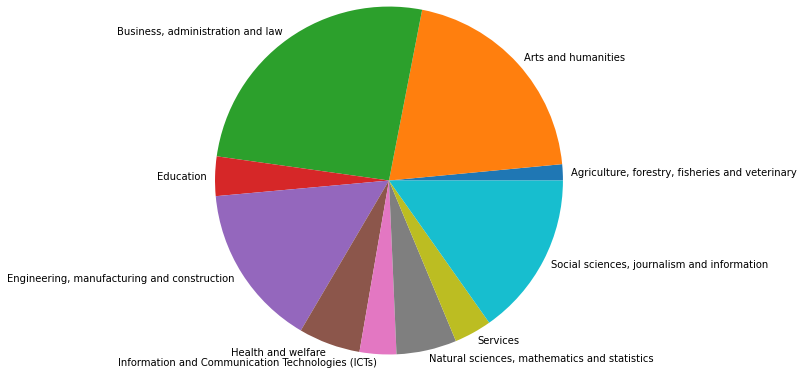

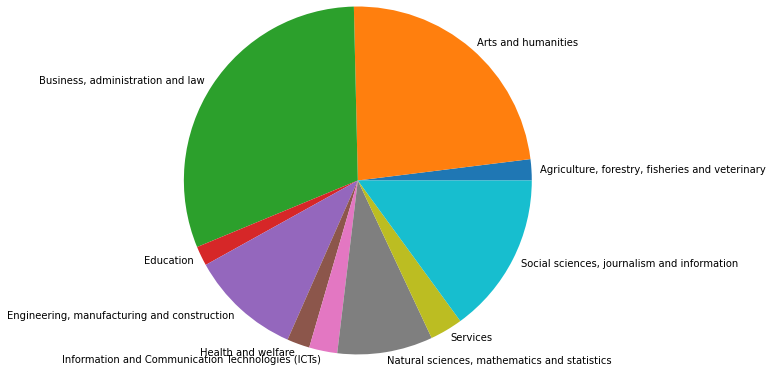

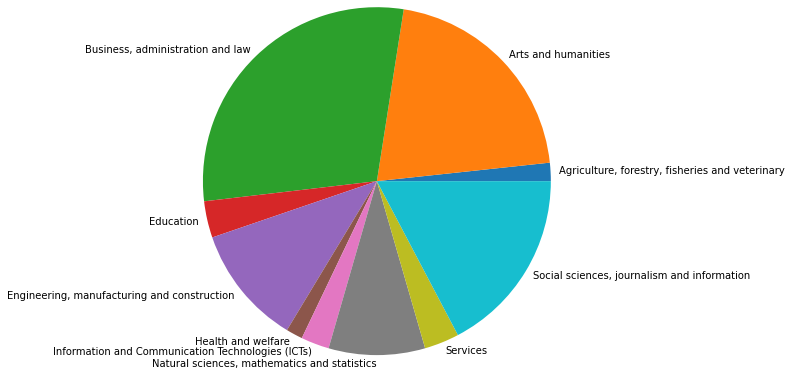

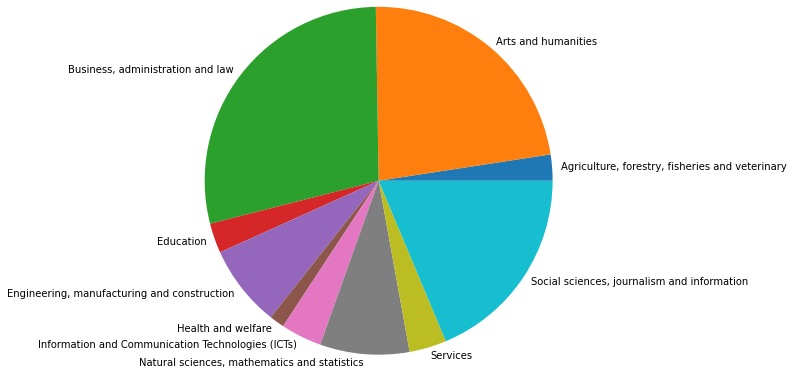

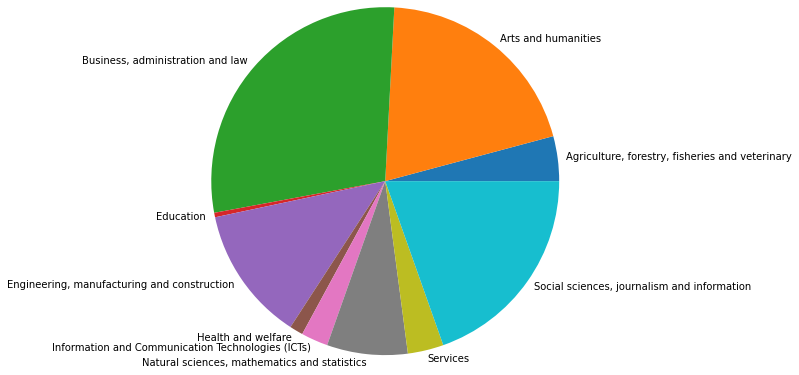

In [28]:
for i, set in enumerate(p):
    for element in set:
        df_w_fields.iat[element, 2]=i
for i, set in enumerate(p):
    if(len(df_w_fields[df_w_fields['Community']==i].index)>3):
        display(df_w_fields[df_w_fields['Community']==i])
print(df_w_fields['Source'].nunique())


for i, set in enumerate(p):
    if(len(df_w_fields[df_w_fields['Community']==i].index)>100):
        com_df = df_w_fields[df_w_fields['Community']==i]
        label = com_df.groupby(['Field of Education']).sum().index.get_level_values('Field of Education').tolist()
        com_df = com_df.groupby(['Field of Education']).sum()
        #display(com_df)
        values = com_df['Quantity']
        #com_df = com1_df['Quantity']/1318*100
        plt.pie(values,labels= label, labeldistance=1.05,radius=2)
        plt.show()

,country,Sending City,Source,Community,Quantity
1,Austria,wien,FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,0,1
7,Serbia,novi sad,UNIVERZITET U NOVOM SADU,0,1
11,Austria,wien,Fachhochschule Technikum Wien,0,1
13,Austria,wien,UNIVERSITAET FUER BODENKULTUR WIEN,0,1
16,Austria,graz,FH JOANNEUM GESELLSCHAFT MBH,0,1
...,...,...,...,...,...
4319,Slovakia,trnava,Univerzita sv. Cyrila a Metoda v Trnave,0,1
4320,Turkey,ankara,ANKARA HACI BAYRAM VELI UNIVERSITESI,0,1
4323,Turkey,serdivan,SAKARYA UYGULAMALI BILIMLER UNIVERSITESI,0,1
4324,Turkey,isparta,Isparta Uygulamali Bilimler Universitesi,0,1


,country,Sending City,Source,Community,Quantity
4,Austria,wien,UNIVERSITAT WIEN,1,1
9,Serbia,beograd,UNIVERZITET U BEOGRADU,1,1
10,Ukraine,lviv,IVAN FRANKO NATIONAL UNIVERSITY OF LVIV,1,1
27,Austria,graz,UNIVERSITAET GRAZ,1,1
30,Bosnia and Herzegovina,sarajevo,UNIVERZITET U SARAJEVU,1,1
...,...,...,...,...,...
4298,Poland,włocławek,Panstwowa Uczelnia Zawodowa we Wloclawku,1,1
4311,Portugal,lisboa,INSTITUTO UNIVERSITARIO DE LISBOA,1,1
4321,Turkey,istanbul,BOGAZICI UNIVERSITESI,1,1
4322,Turkey,konya,KONYA TEKNIK UNIVERSITESI,1,1


,country,Sending City,Source,Community,Quantity
151,Czechia,ostrava,OSTRAVSKA UNIVERZITA,2,1
209,Germany,saarbrücken,Hochschule der Bildenden Künste Saar,2,1
210,Germany,koethen,HOCHSCHULE ANHALT,2,1
217,Germany,alfter,Alanus Hochschule gGmbH,2,1
219,Germany,berlin,Berlin International University of Applied Sci...,2,1
...,...,...,...,...,...
4275,Italy,napoli,Conservatorio San Pietro a Majella,2,1
4276,Italy,siena,"Istituto Superiore di Studi Musicali ""Rinaldo ...",2,1
4277,Italy,san domenico di fiesole fi,FONDAZIONE SCUOLA DI MUSICA DI FIESOLE ONLUS,2,1
4290,Poland,krakow,AKADEMIA MUZYCZNA IM. KRZYSZTOFA PENDERECKIEGO...,2,1


,country,Sending City,Source,Community,Quantity
53,Montenegro,podgorica,University of Donja Gorica,3,1
57,Austria,leoben,MONTANUNIVERSITAT LEOBEN,3,1
58,Ukraine,dnipropetrovsk,NATIONAL MINING UNIVERSITY,3,1
160,Belarus,mogilev,Educational Establishment Mogilev State A.Kule...,3,1
185,Serbia,niš,University of Nis,3,1
...,...,...,...,...,...
4205,France,rennes,OGEC Jean PaulII de la Salle,3,1
4239,Iceland,borgarnes,HASKOLINN A BIFROST SES,3,1
4274,Italy,benevento,Scuola Superiore per Mediatori Linguistici - I...,3,1
4279,Latvia,riga,National Defence Academy of Latvia,3,1


,country,Sending City,Source,Community,Quantity
36,Ukraine,chernivtsi,CHERNIVTSI NATIONAL UNIVERSITY YURIY FEDKOVYCH,4,1
41,Austria,wien,PADAGOGISCHE HOCHSCHULE WIEN,4,1
123,Ukraine,kyiv,NATIONAL DRAGOMANOV PEDAGOGICAL UNIVERSITY OF ...,4,1
126,Ukraine,lviv,HIGHER EDUCATIONAL ESTABLISHMENT UKRAINIAN CAT...,4,1
135,Bulgaria,sofia,SOFIISKI UNIVERSITET SVETI KLIMENT OHRIDSKI,4,1
...,...,...,...,...,...
4136,Spain,valencia,CENTRO UNIVERSITARIO EDEM,4,1
4175,France,pau,Ecole supérieure d'art et de design des Pyrénées,4,1
4283,North Macedonia,sveti nikole,"Megjunaroden Slavjanski Univerzitet ""Gavrilo R...",4,1
4286,Norway,trondheim,DRONNING MAUDS MINNE HØGSKOLE FOR BARNEHAGELÆR...,4,1


,country,Sending City,Source,Community,Quantity
798,Albania,tirana,UNIVERSITY OF NEW YORK TIRANA,5,1
829,France,nice,Communauté d'universités et établissements Uni...,5,1
1328,Turkey,dragos kartal istanbul,ISTANBUL SEHIR UNIVERSITESI,5,1
1354,Albania,tirana,Luarasi University,5,1


,country,Sending City,Source,Community,Quantity
358,Albania,tirana,UNIVERSITETI I MJEKESISE TIRANE,6,1
447,Belarus,vitebsk,Vitebsk State Academy of Veterinary Medicine,6,1
1025,Lithuania,kaunas,LIETUVOS SVEIKATOS MOKSLU UNIVERSITETAS,6,1
1027,"Moldova, Republic of",chisinau,UNIVERSITATEA DE STAT DE MEDICINA SI FARMACIE ...,6,1
1848,Germany,hannover,STIFTUNG TIERAERZTLICHE HOCHSCHULE HANNOVER,6,1
2632,France,toulouse,ECOLE NATIONALE VETERINAIRE DE TOULOUSE,6,1
2862,Hungary,budapest,ALLATORVOSTUDOMANYI EGYETEM,6,1
3072,Ukraine,chernivtsi,Higher State Educational Establishment of Ukra...,6,1
3166,Ukraine,kharkiv,National University of Pharmacy,6,1
3624,Romania,iasi,UNIVERSITATEA DE MEDICINA SI FARMACIE GRIGORE ...,6,1


,country,Sending City,Source,Community,Quantity
215,Germany,neuendettelsau,Augustana-Hochschule,8,1
3298,Norway,oslo,DET TEOLOGISKE MENIGHETSFAKULTET,8,1
3641,Romania,cluj-napoca,Protestant Theological Institute of Cluj-Napoca,8,1
4228,Hungary,sárospatak,Sárospataki Református Teológiai Akadémia,8,1
4229,Hungary,budapest,Evangélikus Hittudományi Egyetem,8,1


,country,Sending City,Source,Community,Quantity
1051,Latvia,riga,INFORMACIJAS SISTEMU MENEDZMENTA AUGSTSKOLA SIA,22,1
1052,Ukraine,kharkiv,SIMON KUZNETS KHARKIV NATIONAL UNIVERSITY OF E...,22,1
1053,Ukraine,cherkasy,Cherkasy state business-college,22,1
4154,Spain,puerto de la cruz,Escuela Superior de Turismo iriarte,22,1


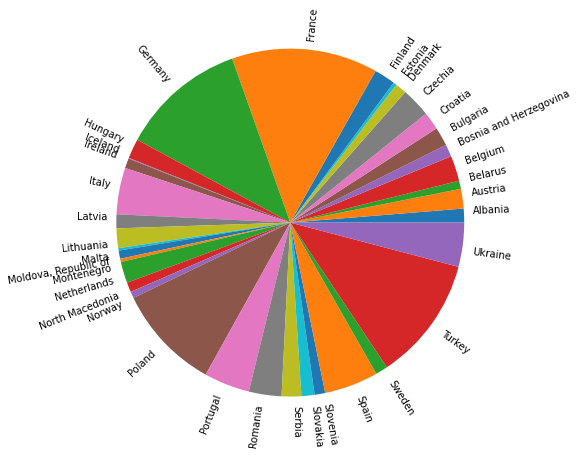

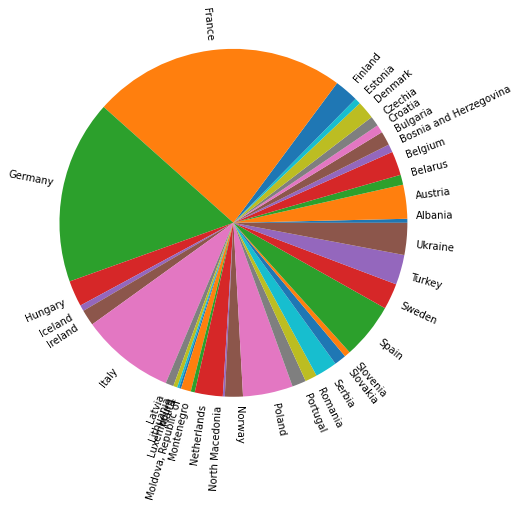

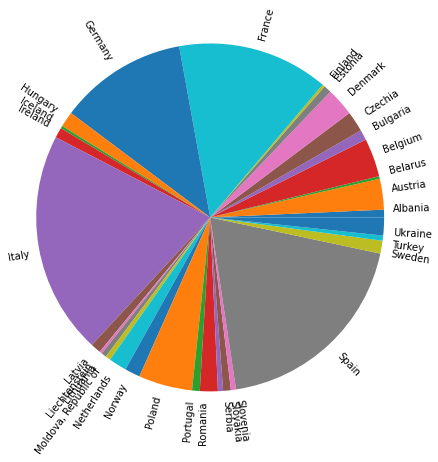

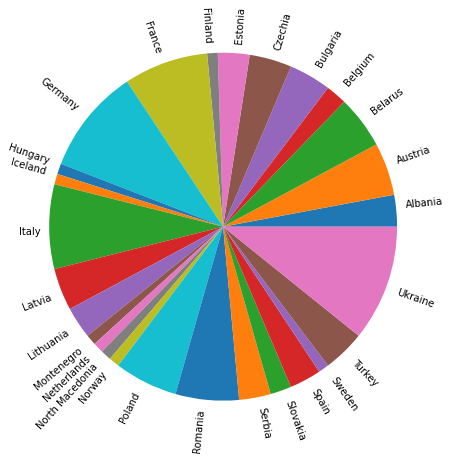

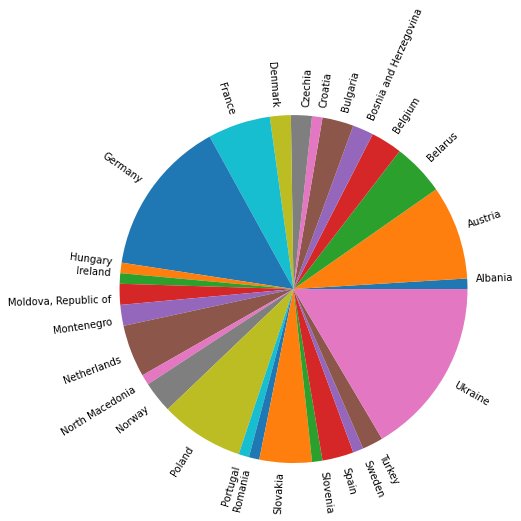

In [8]:
eu_countries = ['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Ukraine', 'Poland', 'Romania', 
                'Netherlands', 'Belgium', 'Czechia', 'Greece', 'Portugal', 'Sweden', 'Hungary', 
                'Belarus', 'Austria', 'Serbia', 'Switzerland', 'Bulgaria', 'Denmark', 'Finland', 'Slovakia', 'Norway',
                'Ireland', 'Croatia', 'Moldova', 'Bosnia and Herzegovina', 'Albania', 'Lithuania', 'Macedonia', 
                'Slovenia', 'Latvia', 'Estonia', 'Montenegro', 'Luxembourg', 'Malta', 'Iceland', 'Andorra', 'Monaco', 
                'Liechtenstein', 'Kosovo', 'Turkey']


node_comm = nodes_df.copy()
#node_comm.drop(columns=['NodeID'], inplace=True)
node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
node_comm['Quantity']=np.ones(len(node_comm.index),dtype='int8')
for i, set in enumerate(p):
    for element in set:
        node_comm.iat[element, 1]=i
node_comm = pd.merge(nodes2,node_comm,how='inner',on='Source')
node_comm.drop(columns=['lat','lng','admin_name','id'], inplace=True)
node_comm = node_comm[node_comm['country'].str.contains('|'.join(eu_countries))==True]
for i, set in enumerate(p):
    if(len(node_comm[node_comm['Community']==i].index)>3):
        display(node_comm[node_comm['Community']==i])


for i, set in enumerate(p):
    if(len(node_comm[node_comm['Community']==i].index)>100):
        com_df = node_comm[node_comm['Community']==i]
        label = com_df.groupby(['country']).sum().index.get_level_values('country').tolist()
        com_df = com_df.groupby(['country']).sum()
        #display(com_df)
        values = com_df['Quantity']
        #com_df = com1_df['Quantity']/1318*100
        plt.pie(values,labels= label, labeldistance=1.05,radius=2, rotatelabels=True)
        plt.show()

# 52 communities. Choose if it makes sense to reduce the number of them 


percentage of foreign languages speaker in europe

In [9]:
language_df = pd.read_csv('data\edat_aes_l26_1_Data.csv', sep=',',low_memory=False, header=0, encoding='utf8')
lan_df = language_df[language_df['TIME']==2016]
l = language_df[language_df['TIME']==2007]
l = l[l['GEO']=='Turkey']
lan_df = lan_df.append(l)
lan_df = lan_df[lan_df['DEG_URB']=='Cities']
lan_df = lan_df[~lan_df['N_LANG'].str.contains('No language')]
lan_df.drop(columns=['TIME','DEG_URB','N_LANG','UNIT','Flag and Footnotes'], inplace= True)
lan_df['Value'] = pd.to_numeric(lan_df['Value'], errors='coerce')
lan_df = lan_df.groupby(['GEO']).sum()
lan_df

,Value
GEO,
Albania,55.0
Austria,93.7
Belgium,81.9
Bosnia and Herzegovina,50.9
Bulgaria,64.3
Croatia,83.2
Cyprus,93.0
Czechia,83.8
Denmark,96.7


In [10]:
uni19_df = pd.read_csv('data\Erasmus19.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(uni19_df)

TypeError: 'frozenset' object is not callable